## OBJECTIF

- Accuracy : 92%
- Loss : 0.20
- Validation Accuracy : 90%
- Validation Loss : 0.25

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 5.0211e-04 - loss: 7.5195 - val_accuracy: 0.0000e+00 - val_loss: 7.5184
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0246 - loss: 7.5077 - val_accuracy: 0.0000e+00 - val_loss: 7.5142
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0154 - loss: 7.4752 - val_accuracy: 0.0000e+00 - val_loss: 7.4981
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0144 - loss: 7.3053 - val_accuracy: 0.0000e+00 - val_loss: 7.6571
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0108 - loss: 6.8171 - val_accuracy: 0.0000e+00 - val_loss: 8.7768
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0106 - loss: 6.5770 - val_accuracy: 0.0000e+00 - val_loss: 8.7214
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0033 - loss: 6.4965 - val_accuracy: 0.0000e+00 - val_loss: 9.1830
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0037 - loss: 6.4691 - val_accu

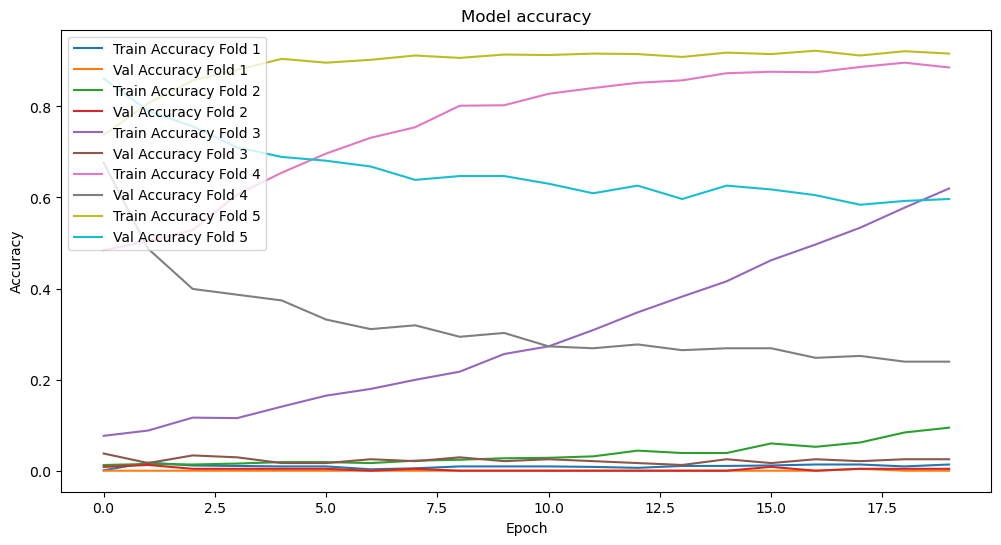

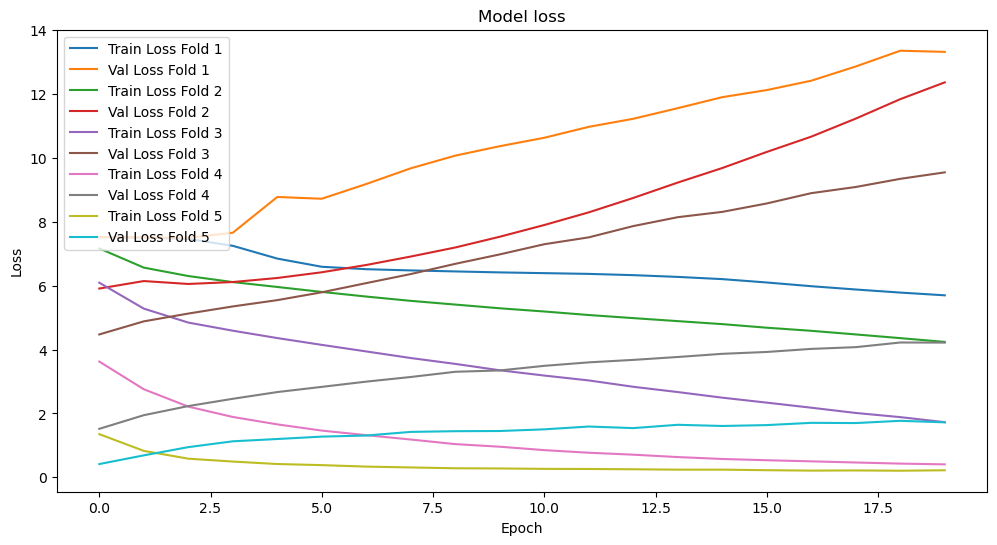

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import warnings
warnings.filterwarnings('ignore')
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load the dataset
df = pd.read_csv('Ecommerce_data.csv')

# Select relevant columns
df = df[['customer_id', 'product_name', 'order_date']]

# Sample 20% of the data for faster processing
df = df.sample(frac=0.2, random_state=1)

# Clean and convert the order_date column to datetime format
df['order_date'] = df['order_date'].str.replace('/', '-')
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True, errors='coerce')

# Sort the dataframe by customer_id and order_date
df = df.sort_values(by=['customer_id', 'order_date'])

# Group by customer_id and aggregate product names into lists
df_grouped = df.groupby('customer_id')['product_name'].apply(list).reset_index()
df_grouped.columns = ['customer_id', 'product_sequence']

# Filter sequences that have exactly three elements
df_grouped = df_grouped[df_grouped['product_sequence'].apply(lambda x: len(x) == 3)]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the product names and transform them to integer codes
df['product_name_indices'] = label_encoder.fit_transform(df['product_name'])

# Prepare the input (X) and output (y) sequences for the LSTM model
X = []
y = []

for sequence in df_grouped['product_sequence']:
    sequence_indices = label_encoder.transform(sequence)
    for i in range(1, len(sequence_indices)):
        X.append(sequence_indices[:i])
        y.append(sequence_indices[i])

# Pad the sequences to ensure uniform input length
X_padded = pad_sequences(X, padding='pre')

# Define the vocabulary size and embedding dimension
vocab_size = len(label_encoder.classes_) + 1
embedding_dim = 100  # Increased embedding dimension
lstm_units = 200  # Increased LSTM units
batch_size = 128  # Adjusted batch size
epochs = 20  # Increased number of epochs

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X_padded.shape[1]))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate the most popular products
popular_products = df['product_name'].value_counts().index.tolist()

# Train the model with K-Fold Cross-Validation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
history_list = []

for train_idx, val_idx in kfold.split(X_padded, y):
    X_train, X_val = X_padded[train_idx], X_padded[val_idx]
    y_train, y_val = np.array(y)[train_idx], np.array(y)[val_idx]

    # Handle cold start for validation
    if len(X_val) == 1:
        y_val = label_encoder.transform(popular_products[:len(y_val)])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    history_list.append(history)

# Function to predict the next products in a sequence
def predict_next_products(sequence, model, label_encoder, top_n=3):
    sequence_indices = label_encoder.transform(sequence)
    sequence_padded = pad_sequences([sequence_indices], maxlen=X_padded.shape[1], padding='pre')
    predictions = model.predict(sequence_padded, verbose=0)[0]
    top_indices = predictions.argsort()[-top_n:][::-1]
    next_products = label_encoder.inverse_transform(top_indices)
    return next_products

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
for i, history in enumerate(history_list):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
for i, history in enumerate(history_list):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [64]:
# Prepare a list of customers
customers = df['customer_id'].unique()[:100]

# Initialize an empty DataFrame to store predictions
predictions_df = pd.DataFrame(columns=['customer_id', 'product_sequence', 'next_products'])

# Predict the next products for each customer
for customer in customers:
    sequence = df.loc[df['customer_id'] == customer, 'product_name'].tolist()
    next_products = predict_next_products(sequence, model, label_encoder)
    predictions_df = pd.concat([predictions_df, pd.DataFrame({'customer_id': [customer], 'product_sequence': [sequence], 'next_products': [next_products]})], ignore_index=True)

# Set display options to see all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show all text in columns

sorted_df = predictions_df.sort_values(by='product_sequence')
sorted_df = sorted_df.reset_index(drop=True)
sorted_df.head(100)


,customer_id,product_sequence,next_products
0,C_ID_25145,"[ARKON Windshield Dashboard Air Vent Car Mount Holder, Deflect-o SuperTray Unbreakable Stackable Tray, Letter, Black]","[Acco Banker's Clasps, 5 3/4""-Long, Sauder Forest Hills Library, Woodland Oak Finish, Toshiba IPT2010-SD IP Telephone]"
1,C_ID_25049,[AT&T 1080 Corded phone],"[Fellowes Bases and Tops For Staxonsteel/High-Stak Systems, Belkin F9M820V08 8 Outlet Surge, Acme Softgrip Scissors]"
2,C_ID_25142,"[AT&T 17929 Lendline Telephone, NETGEAR N750 Dual Band Wi-Fi Gigabit Router]","[Xerox 226, Harmony Air Purifier, AT&T CL2909]"
3,C_ID_25117,[Acco 6 Outlet Guardian Standard Surge Suppressor],"[Adjustable Personal File Tote, Xerox 1942, Fellowes PB300 Plastic Comb Binding Machine]"
4,C_ID_25014,[Acco 6 Outlet Guardian Standard Surge Suppressor],"[Adjustable Personal File Tote, Xerox 1942, Fellowes PB300 Plastic Comb Binding Machine]"
5,C_ID_25111,"[Acco Hot Clips Clips to Go, Zebra GX420t Direct Thermal/Thermal Transfer Printer, DAX Value U-Channel Document Frames, Easel Back]","[SanDisk Ultra 16 GB MicroSDHC Class 10 Memory Card, Flat Face Poster Frame, Sensible Storage WireTech Storage Systems]"
6,C_ID_25158,"[Acme Galleria Hot Forged Steel Scissors with Colored Handles, Stiletto Hand Letter Openers]","[KI Adjustable-Height Table, Southworth 25% Cotton Linen-Finish Paper & Envelopes, GBC Ibimaster 500 Manual ProClick Binding System]"
7,C_ID_25012,"[Acme Office Executive Series Stainless Steel Trimmers, Situations Contoured Folding Chairs, 4/Set, Satellite Sectional Post Binders]","[Fellowes Mighty 8 Compact Surge Protector, KeyTronic E03601U1 - Keyboard - Beige, Xerox 1974]"
8,C_ID_25017,[Acrylic Self-Standing Desk Frames],"[GBC Personal VeloBind Strips, Avery White Multi-Purpose Labels, GBC VeloBinder Electric Binding Machine]"
9,C_ID_25059,"[Adams Telephone Message Book W/Dividers/Space For Phone Numbers, 5 1/4""X8 1/2"", 200/Messages]","[Clear Mylar Reinforcing Strips, O'Sullivan 4-Shelf Bookcase in Odessa Pine, Microsoft Wireless Mobile Mouse 4000]"


In [ ]:
# Export the DataFrame to a CSV file
df_results.to_csv('customer_recommendations.csv', index=False)